In [38]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense 
from tensorflow.keras.optimizers import Adam, RMSprop
import random
import numpy as np
import yfinance as yf
import pandas as pd
from matplotlib import style
style.use('dark_background')

In [63]:
#Euro USD exchange rate
symbol = 'EURUSD=X'
lags = 5

# download from yfinance and calculate returns
raw = yf.download(symbol, start='2010-01-04', end='2019-12-31')
data = raw[['Adj Close']].copy()
data.rename(columns={'Adj Close':'price'}, inplace=True)
data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
data['direction'] = np.where(data['log_returns'] > 0, 1, 0)

# create lag features
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['log_returns'].shift(lag)
    cols.append(col)
    data.dropna(inplace=True)

data.head()

[*********************100%***********************]  1 of 1 completed


,price,log_returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-26,1.408232,-0.004800,0,0.000637,0.003120,-0.000945,-0.012023,-0.008764
2010-01-27,1.403095,-0.003655,0,-0.004800,0.000637,0.003120,-0.000945,-0.012023
2010-01-28,1.396804,-0.004494,0,-0.003655,-0.004800,0.000637,0.003120,-0.000945
2010-01-29,1.386693,-0.007265,0,-0.004494,-0.003655,-0.004800,0.000637,0.003120
2010-02-01,1.392699,0.004322,1,-0.007265,-0.004494,-0.003655,-0.004800,0.000637


In [29]:
# instantiate the optimizer and set the random seed
optimizer = Adam(learning_rate=0.0001)

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

set_seeds()

In [30]:
# instantiate the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu',
input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [31]:
# training and validation set cutoff
cutoff = '2017-12-31'

# training data prep
training_data = data[data.index < cutoff].copy()
# normalize the data (helps when training neural nets)
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

# test data prep
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [40]:
%%time
# train the model
model.fit(training_data[cols],
                    training_data['direction'],
                    epochs=50, verbose=False,
                    validation_split=0.2, shuffle=False)

CPU times: user 5.16 s, sys: 535 ms, total: 5.69 s
Wall time: 3.35 s


<AxesSubplot:>

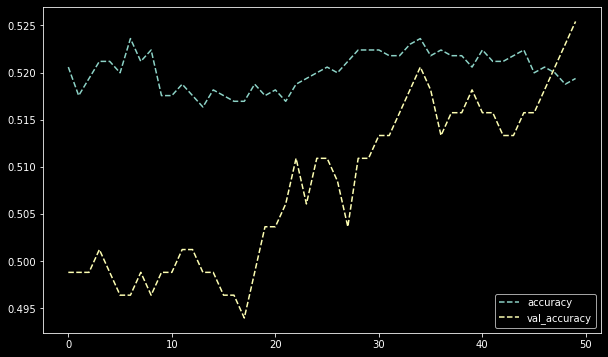

In [41]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [37]:
model.evaluate(training_data_[cols], training_data['direction'])

65/65 [==============================] - 0s 960us/step - loss: 0.7836 - accuracy: 0.5254


[0.783584713935852, 0.5254237055778503]

In [44]:
# where model predicts greater than .5, set equal to 1 (in-sample)
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
# transform into long/short positions
training_data['prediction'] = np.where(pred > 0, 1, -1)
# what we would have made
training_data['strategy'] = (training_data['prediction'] * training_data['log_returns'])
training_data[['log_returns', 'strategy']].sum().apply(np.exp)

log_returns    0.843934
strategy       1.748656
dtype: float64

<AxesSubplot:xlabel='Date'>

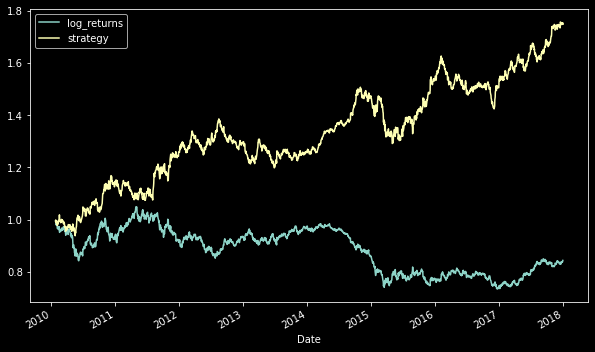

In [46]:
training_data[['log_returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [47]:
# performs better but there were no transaction costs and it was over a period of 8 years.
# this was also in sample. Lets look at out of sample
model.evaluate(test_data_[cols], test_data['direction'])

17/17 [==============================] - 0s 1ms/step - loss: 0.9609 - accuracy: 0.4837


[0.9608668684959412, 0.4836852252483368]

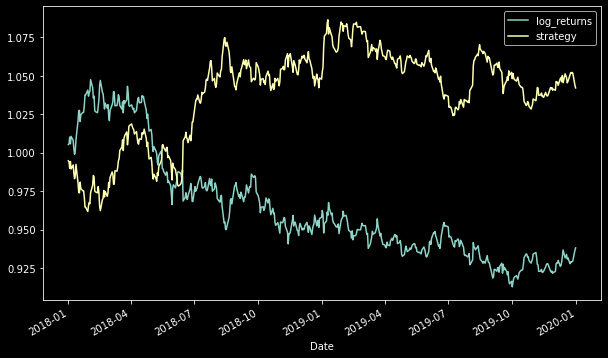

In [49]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['strategy'] = (test_data['prediction'] * test_data['log_returns'])
test_data[['log_returns', 'strategy']].sum().apply(np.exp)
test_data[['log_returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [50]:
# so realistically maybe this strategy would have given you 5%. Keep in mind the accuracy
# out of sample fell slightly below .5 (.49). In the in sample case, the accuracy was just 
# above .5. So if you have a game were you have even slightly better odds than a coin, you
# play iterated games of that and you can make a ton of money. 

In [64]:
data['momentum'] = data['log_returns'].rolling(5).mean().shift(1)
data['volatility'] = data['log_returns'].rolling(20).std().shift(1)
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)
data.dropna(inplace=True)
cols.extend(['momentum', 'volatility', 'distance'])
data.round(4).head()

,price,log_returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2010-04-06,1.3402,-0.0065,0,-0.0012,-0.0058,0.0056,0.0062,-0.0042,0.0001,0.0058,-0.0159
2010-04-07,1.3348,-0.0040,0,-0.0065,-0.0012,-0.0058,0.0056,0.0062,-0.0003,0.0059,-0.0233
2010-04-08,1.3361,0.0009,1,-0.0040,-0.0065,-0.0012,-0.0058,0.0056,-0.0024,0.0059,-0.0272
2010-04-09,1.3501,0.0104,1,0.0009,-0.0040,-0.0065,-0.0012,-0.0058,-0.0033,0.0059,-0.0248
2010-04-12,1.3596,0.0070,1,0.0104,0.0009,-0.0040,-0.0065,-0.0012,-0.0001,0.0062,-0.0101


In [65]:
# spliting the data and normalization
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [66]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
loss='binary_crossentropy',
metrics=['accuracy'])

In [67]:
%%time
model.fit(training_data_[cols], training_data['direction'], verbose=False, epochs=25)

CPU times: user 3.11 s, sys: 320 ms, total: 3.43 s
Wall time: 2.06 s


In [68]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 [==============================] - 0s 801us/step - loss: 0.6803 - accuracy: 0.5663


[0.6802555918693542, 0.566253125667572]

<AxesSubplot:xlabel='Date'>

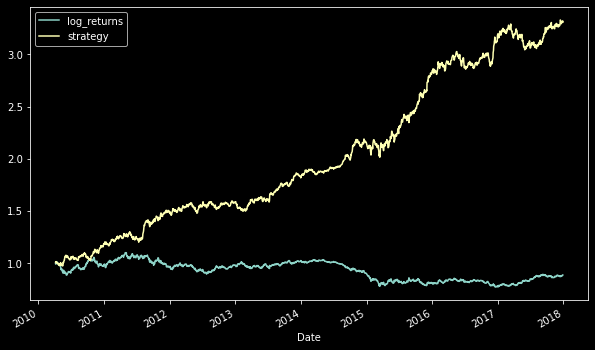

In [70]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] * training_data['log_returns'])
training_data[['log_returns', 'strategy']].sum().apply(np.exp)
training_data[['log_returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [71]:
#out-of-sample
model.evaluate(test_data_[cols], test_data['direction'])

17/17 [==============================] - 0s 986us/step - loss: 0.6929 - accuracy: 0.5202


[0.6929077506065369, 0.5201535224914551]

<AxesSubplot:xlabel='Date'>

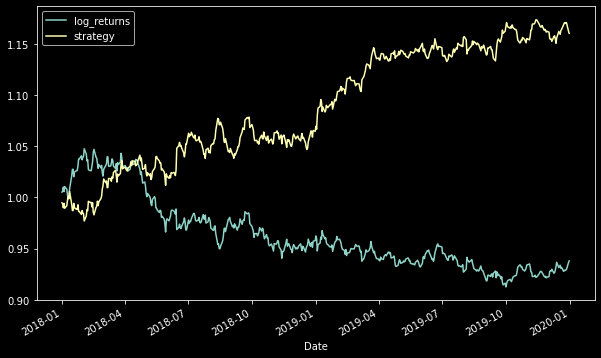

In [73]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['strategy'] = (test_data['prediction'] * test_data['log_returns'])
test_data[['log_returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))